In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import string
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install adabelief-pytorch==0.2.0
from adabelief_pytorch import AdaBelief
from torch.optim import *
import math
from sklearn.metrics import f1_score
!pip install pyarrow
import pandas as pd
!pip install torchviz
from torchviz import make_dot

# GPU info

In [ ]:
! /opt/bin/nvidia-smi

Thu Apr 15 11:18:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    37W / 250W |   4553MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.memory_summary(device=None, abbreviated=False)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transform, split='bymerge')
test_set = torchvision.datasets.EMNIST(root='./data', train=False, download=False, transform=transform, split='bymerge')



cuda:0


# VGG Model
We use a simplified VGGNet compared with standard ones. `VGG_ba_small` in variable `cfg` is used. Compared with VGG 11, some layers are deleted and number of kernels is reduced to 0.25, as shown in `cfg`.

In [3]:
cfg = {
    'VGG_ba_small': [16, 'M', 32, 'M', 64, 'M', 128, 'M', 128, 'M'],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(128 * 7 * 7, 47)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Train and Evaluate Algorithm

In [ ]:
def evaluate(model, valid_dl):

  # we don't want to add evaluation related computation to computation graph
  with torch.no_grad():
    criterion = nn.CrossEntropyLoss()
    valid_loss_lst = torch.tensor([]).to('cuda')
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_valid, y_valid in valid_dl:
      X_valid = X_valid.to('cuda')
      y_valid = y_valid.to('cuda')
      pred = model(X_valid)
      valid_loss_lst = torch.cat((valid_loss_lst, criterion(pred, y_valid).view(-1)))
      predicted = pred.argmax(1).squeeze()
      y_pred_lst = torch.cat((y_pred_lst, predicted))
      y_true_lst = torch.cat((y_true_lst, y_valid))

  return valid_loss_lst.mean().item(), f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')

def train(**params):

  # define model and move it to gpu  
  model = params['model']
  model.to('cuda')

  # define optimizer
  opt = params['optimizer'][0](model.parameters(), **params['optimizer'][1])

  # define data loader
  
  train_dl = DataLoader(params['train_data'], batch_size=params['batch_size'])
  valid_dl = DataLoader(params['test_data'], batch_size=params['batch_size'])

  # define loss
  criterion = torch.nn.CrossEntropyLoss()

  # start training
  valid_loss_lst = []
  train_loss_lst = []
  train_f1_lst = []
  valid_f1_lst = []

  for e in tqdm(range(params['epochs'])):
    train_losses = torch.tensor([]).to('cuda')
    correct = 0
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_train, y_train in train_dl:

      X_train = X_train.to('cuda')
      y_train = y_train.to('cuda')
        
      pred = model(X_train)
      loss = criterion(pred, y_train)

      # perform backward propagation
      loss.backward()

      # update model parameters and clear up gradient after update
      opt.step()
      opt.zero_grad()
      train_losses = torch.cat((train_losses, loss.view(-1)))

      with torch.no_grad():
        predicted = pred.argmax(1).squeeze()
        y_pred_lst = torch.cat((y_pred_lst, predicted))
        y_true_lst = torch.cat((y_true_lst, y_train))
      
        
    valid_loss, valid_f1 = evaluate(model, valid_dl)
    train_loss = train_losses.mean().item()
    train_f1 = f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')
    train_loss_lst.append(train_loss)
    valid_loss_lst.append(valid_loss)
    train_f1_lst.append(train_f1)
    valid_f1_lst.append(valid_f1)
    

    print(f'epoch: {e}, training loss: {train_loss}, training f1: {train_f1}, validation loss: {valid_loss}, validation f1: {valid_f1}')

  return model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst

#Train VGG with different optimizers and evaluate
** As mentioned, VGG is a simplified version

# Optimizer 1: SGD + Momentum
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
my_vgg_SGD = VGG('VGG_ba_small')
params = {
    'optimizer': (torch.optim.SGD, {'lr': 0.0005, 'momentum': 0.9}),
    'model': my_vgg_SGD,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_SGD, train_loss_lst_SGD, valid_loss_lst_SGD, train_f1_lst_SGD, valid_f1_lst_SGD = train(**params)

  3%|▎         | 1/30 [18:10<8:47:04, 1090.49s/it]

epoch: 0, training loss: 0.4688056409358978, training f1: 0.8456654803046715, validation loss: 0.37327808141708374, validation f1: 0.8721319085649442


  7%|▋         | 2/30 [36:22<8:29:06, 1090.95s/it]

epoch: 1, training loss: 0.347472220659256, training f1: 0.8782574806714695, validation loss: 0.3389529585838318, validation f1: 0.8810983210543056


 10%|█         | 3/30 [54:25<8:09:52, 1088.63s/it]

epoch: 2, training loss: 0.3234083652496338, training f1: 0.8850203171655693, validation loss: 0.3243304491043091, validation f1: 0.8837289272112995


 13%|█▎        | 4/30 [1:12:29<7:51:08, 1087.23s/it]

epoch: 3, training loss: 0.309419184923172, training f1: 0.8889089481496765, validation loss: 0.3148881494998932, validation f1: 0.8870730637964976


 17%|█▋        | 5/30 [1:30:35<7:32:52, 1086.90s/it]

epoch: 4, training loss: 0.30015066266059875, training f1: 0.8915553377692956, validation loss: 0.3095610737800598, validation f1: 0.8887236402087292


 20%|██        | 6/30 [1:48:37<7:14:09, 1085.41s/it]

epoch: 5, training loss: 0.2930055856704712, training f1: 0.8941157591283965, validation loss: 0.29966476559638977, validation f1: 0.8915003911522227


 23%|██▎       | 7/30 [2:06:28<6:54:24, 1081.09s/it]

epoch: 6, training loss: 0.28703799843788147, training f1: 0.895488385688004, validation loss: 0.29709145426750183, validation f1: 0.893572208419659


 27%|██▋       | 8/30 [2:24:19<6:35:14, 1077.91s/it]

epoch: 7, training loss: 0.28179457783699036, training f1: 0.8970458440077258, validation loss: 0.2936166226863861, validation f1: 0.8944920608993923


 30%|███       | 9/30 [2:42:04<6:15:54, 1074.05s/it]

epoch: 8, training loss: 0.2777079641819, training f1: 0.8983611583936545, validation loss: 0.2903459072113037, validation f1: 0.8951368173104202


 33%|███▎      | 10/30 [2:59:52<5:57:26, 1072.35s/it]

epoch: 9, training loss: 0.2735957205295563, training f1: 0.8994214336067125, validation loss: 0.2901502847671509, validation f1: 0.8948359309852738


 37%|███▋      | 11/30 [3:17:48<5:39:51, 1073.25s/it]

epoch: 10, training loss: 0.27184611558914185, training f1: 0.899824051626806, validation loss: 0.28522998094558716, validation f1: 0.8978361974845903


 40%|████      | 12/30 [3:35:34<5:21:23, 1071.30s/it]

epoch: 11, training loss: 0.2682205140590668, training f1: 0.9012812136425898, validation loss: 0.2840608060359955, validation f1: 0.8978963747496196


 43%|████▎     | 13/30 [3:53:26<5:03:34, 1071.45s/it]

epoch: 12, training loss: 0.26516929268836975, training f1: 0.9019703925310776, validation loss: 0.2822911739349365, validation f1: 0.8977158429545318


 47%|████▋     | 14/30 [4:11:11<4:45:14, 1069.63s/it]

epoch: 13, training loss: 0.2627596855163574, training f1: 0.9028730592665188, validation loss: 0.28089040517807007, validation f1: 0.8981284870575896


 50%|█████     | 15/30 [4:28:56<4:27:03, 1068.21s/it]

epoch: 14, training loss: 0.26051875948905945, training f1: 0.9031467248958351, validation loss: 0.28021901845932007, validation f1: 0.8985755181692356


 53%|█████▎    | 16/30 [4:46:40<4:08:56, 1066.90s/it]

epoch: 15, training loss: 0.2589694559574127, training f1: 0.9037843228280119, validation loss: 0.27934759855270386, validation f1: 0.8984723571434712


 57%|█████▋    | 17/30 [5:04:14<3:50:18, 1062.96s/it]

epoch: 16, training loss: 0.2570180594921112, training f1: 0.904453442455712, validation loss: 0.2786213457584381, validation f1: 0.8989365817594113


 60%|██████    | 18/30 [5:21:50<3:32:10, 1060.92s/it]

epoch: 17, training loss: 0.25500014424324036, training f1: 0.9052830361697128, validation loss: 0.277706503868103, validation f1: 0.899099920050205


 63%|██████▎   | 19/30 [5:39:33<3:14:38, 1061.65s/it]

epoch: 18, training loss: 0.25314927101135254, training f1: 0.9056312076248116, validation loss: 0.27669623494148254, validation f1: 0.8988162272293527


 67%|██████▋   | 20/30 [5:57:32<2:57:45, 1066.59s/it]

epoch: 19, training loss: 0.25163376331329346, training f1: 0.9061054658620038, validation loss: 0.27351653575897217, validation f1: 0.899770466717674


 70%|███████   | 21/30 [6:15:18<2:39:59, 1066.62s/it]

epoch: 20, training loss: 0.25019416213035583, training f1: 0.9064163844042114, validation loss: 0.27399367094039917, validation f1: 0.9009740120182596


 73%|███████▎  | 22/30 [6:33:01<2:22:03, 1065.39s/it]

epoch: 21, training loss: 0.2483709752559662, training f1: 0.9068705833806159, validation loss: 0.27514785528182983, validation f1: 0.8998306439827033


 77%|███████▋  | 23/30 [6:50:44<2:04:13, 1064.74s/it]

epoch: 22, training loss: 0.24727194011211395, training f1: 0.9070496839233622, validation loss: 0.27127891778945923, validation f1: 0.9010169957789947


 80%|████████  | 24/30 [7:08:21<1:46:14, 1062.48s/it]

epoch: 23, training loss: 0.24585475027561188, training f1: 0.907728833181456, validation loss: 0.2711344063282013, validation f1: 0.9011545438133475


 83%|████████▎ | 25/30 [7:26:06<1:28:35, 1063.06s/it]

epoch: 24, training loss: 0.24487142264842987, training f1: 0.908115690353788, validation loss: 0.27036699652671814, validation f1: 0.9020314125323453


 87%|████████▋ | 26/30 [7:43:51<1:10:54, 1063.68s/it]

epoch: 25, training loss: 0.24361203610897064, training f1: 0.9085684565258506, validation loss: 0.2718549966812134, validation f1: 0.9002948685986434


 90%|█████████ | 27/30 [8:01:28<53:04, 1061.61s/it]  

epoch: 26, training loss: 0.24218565225601196, training f1: 0.9090642068281723, validation loss: 0.2700176239013672, validation f1: 0.9020228157801984


 93%|█████████▎| 28/30 [8:19:13<35:25, 1062.76s/it]

epoch: 27, training loss: 0.24115371704101562, training f1: 0.9091659359364522, validation loss: 0.27082470059394836, validation f1: 0.9009740120182596


 97%|█████████▋| 29/30 [8:37:01<17:44, 1064.42s/it]

epoch: 28, training loss: 0.24029499292373657, training f1: 0.9097189984124527, validation loss: 0.2696806788444519, validation f1: 0.9007762867188777


100%|██████████| 30/30 [8:54:54<00:00, 1069.82s/it]

epoch: 29, training loss: 0.2386067807674408, training f1: 0.9099826344113753, validation loss: 0.2700476050376892, validation f1: 0.9010513827875829


In [ ]:
import pandas as pd
sgd_df = pd.DataFrame(data={'train_loss': train_loss_lst_SGD, 
                            'valid_loss': valid_loss_lst_SGD, 
                            'train_f1': train_f1_lst_SGD, 
                            'valid_f1': valid_f1_lst_SGD, 
                            'category': ['sgd']*len(train_loss_lst_SGD)})

sgd_df.to_parquet('./sgd_results.parquet')

# Optimizer 2: Adam
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
my_vgg_Adam = VGG('VGG_ba_small')
params = {
    'optimizer': (torch.optim.Adam, {'lr': 0.0005}),
    'model': my_vgg_Adam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_Adam, train_loss_lst_Adam, valid_loss_lst_Adam, train_f1_lst_Adam, valid_f1_lst_Adam = train(**params)

  3%|▎         | 1/30 [18:19<8:51:15, 1099.15s/it]

epoch: 0, training loss: 0.40286922454833984, training f1: 0.8634279557320771, validation loss: 0.3221478760242462, validation f1: 0.8847777309732382


  7%|▋         | 2/30 [36:37<8:32:46, 1098.79s/it]

epoch: 1, training loss: 0.30247145891189575, training f1: 0.8910380954018443, validation loss: 0.2954317033290863, validation f1: 0.8929790325215133


 10%|█         | 3/30 [55:06<8:15:55, 1102.06s/it]

epoch: 2, training loss: 0.2806757092475891, training f1: 0.8976476218313532, validation loss: 0.2868461012840271, validation f1: 0.8965982651754167


 13%|█▎        | 4/30 [1:13:38<7:58:49, 1104.97s/it]

epoch: 3, training loss: 0.26887819170951843, training f1: 0.901321332164165, validation loss: 0.28105276823043823, validation f1: 0.8975782949201792


 17%|█▋        | 5/30 [1:32:07<7:40:57, 1106.29s/it]

epoch: 4, training loss: 0.2605642080307007, training f1: 0.9038659926755042, validation loss: 0.2783723473548889, validation f1: 0.8983004221005304


 20%|██        | 6/30 [1:50:38<7:23:03, 1107.66s/it]

epoch: 5, training loss: 0.25421807169914246, training f1: 0.9055982531249462, validation loss: 0.2750374972820282, validation f1: 0.9005527711630545


 23%|██▎       | 7/30 [2:09:09<7:04:55, 1108.49s/it]

epoch: 6, training loss: 0.24910643696784973, training f1: 0.9069866405323155, validation loss: 0.27534496784210205, validation f1: 0.9006387386845249


 27%|██▋       | 8/30 [2:27:44<6:47:10, 1110.46s/it]

epoch: 7, training loss: 0.2450942099094391, training f1: 0.9081830321578607, validation loss: 0.2729085683822632, validation f1: 0.9007161094538484


 30%|███       | 9/30 [2:46:25<6:29:44, 1113.56s/it]

epoch: 8, training loss: 0.24179452657699585, training f1: 0.9092461729796026, validation loss: 0.2720339298248291, validation f1: 0.9015070106513761


 33%|███▎      | 10/30 [3:05:10<6:12:21, 1117.07s/it]

epoch: 9, training loss: 0.23857054114341736, training f1: 0.9099195910203286, validation loss: 0.2744884490966797, validation f1: 0.9018508807372575


 37%|███▋      | 11/30 [3:23:53<5:54:17, 1118.82s/it]

epoch: 10, training loss: 0.23578909039497375, training f1: 0.9107119318214382, validation loss: 0.27231869101524353, validation f1: 0.901730526207199


 40%|████      | 12/30 [3:42:32<5:35:40, 1118.93s/it]

epoch: 11, training loss: 0.23271776735782623, training f1: 0.9118982938165896, validation loss: 0.2717337906360626, validation f1: 0.9016961391986109


 43%|████▎     | 13/30 [4:01:02<5:16:19, 1116.42s/it]

epoch: 12, training loss: 0.23052245378494263, training f1: 0.9124427594665383, validation loss: 0.27160316705703735, validation f1: 0.9016617521900226


 47%|████▋     | 14/30 [4:19:44<4:58:06, 1117.88s/it]

epoch: 13, training loss: 0.22808855772018433, training f1: 0.9130072843772746, validation loss: 0.2716122567653656, validation f1: 0.9020228157801984


 50%|█████     | 15/30 [4:38:33<4:40:20, 1121.37s/it]

epoch: 14, training loss: 0.22591285407543182, training f1: 0.9135130643099902, validation loss: 0.27389824390411377, validation f1: 0.9021173800538157


 53%|█████▎    | 16/30 [4:57:28<4:22:34, 1125.36s/it]

epoch: 15, training loss: 0.2239813506603241, training f1: 0.914286778654654, validation loss: 0.27228400111198425, validation f1: 0.9020486060366394


 57%|█████▋    | 17/30 [5:16:21<4:04:18, 1127.60s/it]

epoch: 16, training loss: 0.2218758761882782, training f1: 0.9148126178481572, validation loss: 0.2738974392414093, validation f1: 0.9023237021053446


 60%|██████    | 18/30 [5:35:17<3:46:02, 1130.21s/it]

epoch: 17, training loss: 0.21983864903450012, training f1: 0.9155548104972977, validation loss: 0.27505987882614136, validation f1: 0.90152420415567


 63%|██████▎   | 19/30 [5:54:02<3:26:55, 1128.70s/it]

epoch: 18, training loss: 0.2186262607574463, training f1: 0.9160777840821169, validation loss: 0.27431720495224, validation f1: 0.9018422839851105


 67%|██████▋   | 20/30 [6:12:40<3:07:33, 1125.32s/it]

epoch: 19, training loss: 0.21704722940921783, training f1: 0.9166093544929879, validation loss: 0.2746519446372986, validation f1: 0.9026675721912262


 70%|███████   | 21/30 [6:31:18<2:48:29, 1123.32s/it]

epoch: 20, training loss: 0.2152322232723236, training f1: 0.9167712613836305, validation loss: 0.2745105028152466, validation f1: 0.9023408956096386


 73%|███████▎  | 22/30 [6:49:54<2:29:28, 1121.04s/it]

epoch: 21, training loss: 0.21325889229774475, training f1: 0.9173429503160766, validation loss: 0.27924612164497375, validation f1: 0.900845060736054


 77%|███████▋  | 23/30 [7:08:34<2:10:45, 1120.81s/it]

epoch: 22, training loss: 0.21258139610290527, training f1: 0.9176796593364397, validation loss: 0.2798953950405121, validation f1: 0.9007934802231717


 80%|████████  | 24/30 [7:27:18<1:52:10, 1121.72s/it]

epoch: 23, training loss: 0.21045221388339996, training f1: 0.9183530773771656, validation loss: 0.2781837582588196, validation f1: 0.9013952528734644


 83%|████████▎ | 25/30 [7:45:37<1:32:53, 1114.72s/it]

epoch: 24, training loss: 0.20900623500347137, training f1: 0.9186267430064821, validation loss: 0.2791272699832916, validation f1: 0.9013264788562881


 87%|████████▋ | 26/30 [8:03:59<1:14:03, 1110.94s/it]

epoch: 25, training loss: 0.20740722119808197, training f1: 0.9191826710911665, validation loss: 0.28190305829048157, validation f1: 0.9019798320194631


 90%|█████████ | 27/30 [8:22:14<55:18, 1106.33s/it]  

epoch: 26, training loss: 0.20646682381629944, training f1: 0.919735733567167, validation loss: 0.2815832495689392, validation f1: 0.9014038496256115


 93%|█████████▎| 28/30 [8:40:30<36:46, 1103.30s/it]

epoch: 27, training loss: 0.2051573246717453, training f1: 0.9199879071313538, validation loss: 0.28116896748542786, validation f1: 0.9021173800538157


 97%|█████████▋| 29/30 [8:58:55<18:23, 1103.58s/it]

epoch: 28, training loss: 0.20441581308841705, training f1: 0.920023727239903, validation loss: 0.2820988893508911, validation f1: 0.9019540417630221


100%|██████████| 30/30 [9:17:21<00:00, 1114.73s/it]

epoch: 29, training loss: 0.20308013260364532, training f1: 0.9205724913028777, validation loss: 0.2840149700641632, validation f1: 0.9009396250096714


In [ ]:
adam_df =  pd.DataFrame(data={'train_loss': train_loss_lst_Adam, 
                            'valid_loss': valid_loss_lst_Adam, 
                            'train_f1': train_f1_lst_Adam, 
                            'valid_f1': valid_f1_lst_Adam, 
                            'category': ['adam']*len(train_loss_lst_Adam)})

adam_df.to_parquet('./adam_results.parquet')

# Optimizer 3: AdaBelief
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
my_vgg_AdaBelief = VGG('VGG_ba_small')
params = {
    'optimizer': (AdaBelief, {'lr': 0.0005}),
    'model': my_vgg_AdaBelief,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_AdaBelief, train_loss_lst_AdaBelief, valid_loss_lst_AdaBelief, train_f1_lst_AdaBelief, valid_f1_lst_AdaBelief = train(**params)

  0%|          | 0/30 [00:00<?, ?it/s]

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


  3%|▎         | 1/30 [18:24<8:53:42, 1104.22s/it]

epoch: 0, training loss: 0.43477001786231995, training f1: 0.8553970873953337, validation loss: 0.32757049798965454, validation f1: 0.8837203304591525


  7%|▋         | 2/30 [36:36<8:33:33, 1100.49s/it]

epoch: 1, training loss: 0.3049285113811493, training f1: 0.8906942223597715, validation loss: 0.29682132601737976, validation f1: 0.8932885155988067


 10%|█         | 3/30 [54:46<8:13:54, 1097.58s/it]

epoch: 2, training loss: 0.2810872793197632, training f1: 0.897654785853063, validation loss: 0.28545081615448, validation f1: 0.897320392355768


 13%|█▎        | 4/30 [1:12:54<7:54:19, 1094.58s/it]

epoch: 3, training loss: 0.2686302959918976, training f1: 0.9013456898379784, validation loss: 0.281249463558197, validation f1: 0.8994437901360866


 17%|█▋        | 5/30 [1:31:00<7:35:00, 1092.01s/it]

epoch: 4, training loss: 0.26011979579925537, training f1: 0.9040107059140432, validation loss: 0.2756127119064331, validation f1: 0.899976788769203


 20%|██        | 6/30 [1:49:06<7:16:02, 1090.10s/it]

epoch: 5, training loss: 0.2536384165287018, training f1: 0.906092570622926, validation loss: 0.27372750639915466, validation f1: 0.9010513827875829


 23%|██▎       | 7/30 [2:07:11<6:57:21, 1088.74s/it]

epoch: 6, training loss: 0.24863563477993011, training f1: 0.9074637643781915, validation loss: 0.2744995355606079, validation f1: 0.9006817224452602


 27%|██▋       | 8/30 [2:25:18<6:38:59, 1088.14s/it]

epoch: 7, training loss: 0.24400635063648224, training f1: 0.9083993856134982, validation loss: 0.2709735631942749, validation f1: 0.9021517670624039


 30%|███       | 9/30 [2:43:26<6:20:51, 1088.16s/it]

epoch: 8, training loss: 0.24078591167926788, training f1: 0.9095040777611573, validation loss: 0.27004462480545044, validation f1: 0.9022463313360213


 33%|███▎      | 10/30 [3:01:32<6:02:28, 1087.41s/it]

epoch: 9, training loss: 0.23727594316005707, training f1: 0.9105557561481634, validation loss: 0.27049514651298523, validation f1: 0.9026159916783439


 37%|███▋      | 11/30 [3:19:41<5:44:32, 1088.04s/it]

epoch: 10, training loss: 0.2343207746744156, training f1: 0.9112821879495424, validation loss: 0.2692781388759613, validation f1: 0.9026761689433732


 40%|████      | 12/30 [3:37:49<5:26:20, 1087.83s/it]

epoch: 11, training loss: 0.23171910643577576, training f1: 0.9121604970111702, validation loss: 0.27063000202178955, validation f1: 0.9027793299691376


 43%|████▎     | 13/30 [3:56:00<5:08:31, 1088.93s/it]

epoch: 12, training loss: 0.22941969335079193, training f1: 0.9125588166182379, validation loss: 0.2714511454105377, validation f1: 0.9025816046697558


 47%|████▋     | 14/30 [4:14:05<4:50:03, 1087.72s/it]

epoch: 13, training loss: 0.22693848609924316, training f1: 0.9135030346795963, validation loss: 0.2731008231639862, validation f1: 0.9020056222759042


 50%|█████     | 15/30 [4:32:18<4:32:20, 1089.37s/it]

epoch: 14, training loss: 0.2242438793182373, training f1: 0.9142122728288716, validation loss: 0.2730100452899933, validation f1: 0.9027535397126966


 53%|█████▎    | 16/30 [4:50:22<4:13:48, 1087.75s/it]

epoch: 15, training loss: 0.22269326448440552, training f1: 0.9147639025005302, validation loss: 0.2735563814640045, validation f1: 0.9022893150967565


 57%|█████▋    | 17/30 [5:08:28<3:55:34, 1087.28s/it]

epoch: 16, training loss: 0.22020767629146576, training f1: 0.9152926073027172, validation loss: 0.27331340312957764, validation f1: 0.9033811026194305


 60%|██████    | 18/30 [5:26:33<3:37:18, 1086.57s/it]

epoch: 17, training loss: 0.21903349459171295, training f1: 0.9156393459534741, validation loss: 0.27450132369995117, validation f1: 0.9026073949261969


 63%|██████▎   | 19/30 [5:44:40<3:19:13, 1086.70s/it]

epoch: 18, training loss: 0.21724247932434082, training f1: 0.9165620719497029, validation loss: 0.2753930687904358, validation f1: 0.9027621364648436


 67%|██████▋   | 20/30 [6:02:45<3:01:01, 1086.12s/it]

epoch: 19, training loss: 0.21585610508918762, training f1: 0.9168744232962523, validation loss: 0.27385830879211426, validation f1: 0.902186154070992


 70%|███████   | 21/30 [6:20:50<2:42:51, 1085.67s/it]

epoch: 20, training loss: 0.2140270173549652, training f1: 0.9170936423605738, validation loss: 0.2768348157405853, validation f1: 0.9016789456943168


 73%|███████▎  | 22/30 [6:39:02<2:25:00, 1087.59s/it]

epoch: 21, training loss: 0.211896151304245, training f1: 0.9179318329006264, validation loss: 0.2775590121746063, validation f1: 0.9023408956096386


 77%|███████▋  | 23/30 [6:57:16<2:07:06, 1089.55s/it]

epoch: 22, training loss: 0.21096906065940857, training f1: 0.9182026329212588, validation loss: 0.2780243158340454, validation f1: 0.9023580891139328


 80%|████████  | 24/30 [7:15:30<1:49:05, 1090.99s/it]

epoch: 23, training loss: 0.20996874570846558, training f1: 0.9185937885066167, validation loss: 0.2796558439731598, validation f1: 0.9027707332169906


 83%|████████▎ | 25/30 [7:33:44<1:30:59, 1091.94s/it]

epoch: 24, training loss: 0.20798982679843903, training f1: 0.9191167620914359, validation loss: 0.27770447731018066, validation f1: 0.9025902014219028


 87%|████████▋ | 26/30 [7:51:59<1:12:51, 1092.91s/it]

epoch: 25, training loss: 0.20633390545845032, training f1: 0.9197185399150634, validation loss: 0.2818041145801544, validation f1: 0.9019540417630221


 90%|█████████ | 27/30 [8:10:15<54:41, 1093.74s/it]  

epoch: 26, training loss: 0.2047368735074997, training f1: 0.9201168595221311, validation loss: 0.2819083034992218, validation f1: 0.9014898171470819


 93%|█████████▎| 28/30 [8:28:29<36:27, 1093.82s/it]

epoch: 27, training loss: 0.20370671153068542, training f1: 0.9206727876068156, validation loss: 0.28453686833381653, validation f1: 0.9014640268906408


 97%|█████████▋| 29/30 [8:46:44<18:14, 1094.05s/it]

epoch: 28, training loss: 0.2029600590467453, training f1: 0.9206584595633959, validation loss: 0.28615477681159973, validation f1: 0.9009482217618185


100%|██████████| 30/30 [9:04:59<00:00, 1089.98s/it]

epoch: 29, training loss: 0.2014610469341278, training f1: 0.9212616701913654, validation loss: 0.28367671370506287, validation f1: 0.9011631405654945


In [ ]:

belief_df = pd.DataFrame(data={'train_loss': train_loss_lst_AdaBelief, 
                            'valid_loss': valid_loss_lst_AdaBelief, 
                            'train_f1': train_f1_lst_AdaBelief, 
                            'valid_f1': valid_f1_lst_AdaBelief, 
                            'category': ['belief']*len(train_loss_lst_AdaBelief)})

belief_df.to_parquet('./belief_results.parquet')

# Optimizer 4: Padam
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
class Padam(Optimizer):
    """Implements Partially adaptive momentum estimation (Padam) algorithm.
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-1)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        partial (float, optional): partially adaptive parameter
    """

    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True, partial = 1/4):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, partial = partial)
        super(Padam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                partial = group['partial']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom**(partial*2))
                
        return loss


In [ ]:
my_vgg_Padam = VGG('VGG_ba_small')
params = {
    'optimizer': (Padam, {'lr': 0.0005}),
    'model': my_vgg_Padam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_Padam, train_loss_lst_Padam, valid_loss_lst_Padam, train_f1_lst_Padam, valid_f1_lst_Padam = train(**params)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  3%|▎         | 1/30 [21:11<10:14:26, 1271.26s/it]

epoch: 0, training loss: 0.4918713867664337, training f1: 0.8412610397574549, validation loss: 0.36202165484428406, validation f1: 0.8739544200201164


  7%|▋         | 2/30 [42:01<9:50:20, 1265.01s/it] 

epoch: 1, training loss: 0.33975666761398315, training f1: 0.8810414195079177, validation loss: 0.3343052268028259, validation f1: 0.8827574942186842


 10%|█         | 3/30 [1:02:51<9:27:13, 1260.49s/it]

epoch: 2, training loss: 0.31622636318206787, training f1: 0.8878587025670123, validation loss: 0.31709182262420654, validation f1: 0.8872364020872915


 13%|█▎        | 4/30 [1:23:43<9:05:08, 1258.01s/it]

epoch: 3, training loss: 0.30296435952186584, training f1: 0.8915066224216686, validation loss: 0.3083551228046417, validation f1: 0.8904859743988721


 17%|█▋        | 5/30 [1:44:03<8:39:20, 1246.40s/it]

epoch: 4, training loss: 0.294445276260376, training f1: 0.8940598797590597, validation loss: 0.3009522259235382, validation f1: 0.8923944533755147


 20%|██        | 6/30 [2:04:12<8:14:07, 1235.31s/it]

epoch: 5, training loss: 0.2871372401714325, training f1: 0.895919659794937, validation loss: 0.29696330428123474, validation f1: 0.8927469202135433


 23%|██▎       | 7/30 [2:24:58<7:54:43, 1238.40s/it]

epoch: 6, training loss: 0.2819531261920929, training f1: 0.8974728197016328, validation loss: 0.29258614778518677, validation f1: 0.8936495791889822


 27%|██▋       | 8/30 [2:45:26<7:32:59, 1235.42s/it]

epoch: 7, training loss: 0.27713730931282043, training f1: 0.8986763753488879, validation loss: 0.2907208502292633, validation f1: 0.8944576738908041


 30%|███       | 9/30 [3:06:04<7:12:36, 1236.02s/it]

epoch: 8, training loss: 0.2729024887084961, training f1: 0.9001922823426924, validation loss: 0.2874215245246887, validation f1: 0.8962887820981233


 33%|███▎      | 10/30 [3:26:40<6:52:01, 1236.09s/it]

epoch: 9, training loss: 0.26946839690208435, training f1: 0.9011508284474705, validation loss: 0.2841866910457611, validation f1: 0.896649845688299


 37%|███▋      | 11/30 [3:46:58<6:29:43, 1230.69s/it]

epoch: 10, training loss: 0.2664623260498047, training f1: 0.9019718253354195, validation loss: 0.28220969438552856, validation f1: 0.8977932137238551


 40%|████      | 12/30 [4:07:02<6:06:46, 1222.59s/it]

epoch: 11, training loss: 0.2637288570404053, training f1: 0.9028673280491509, validation loss: 0.2809002101421356, validation f1: 0.8983004221005304


 43%|████▎     | 13/30 [4:27:26<5:46:32, 1223.08s/it]

epoch: 12, training loss: 0.2610093355178833, training f1: 0.9034476138076489, validation loss: 0.28240007162094116, validation f1: 0.8974751338944147


 47%|████▋     | 14/30 [4:47:45<5:25:50, 1221.93s/it]

epoch: 13, training loss: 0.2590523660182953, training f1: 0.9040852117398256, validation loss: 0.2775588929653168, validation f1: 0.8991171135544991


 50%|█████     | 15/30 [5:08:00<5:04:55, 1219.69s/it]

epoch: 14, training loss: 0.25620603561401367, training f1: 0.9050236985838161, validation loss: 0.27653440833091736, validation f1: 0.899538354409704


 53%|█████▎    | 16/30 [5:28:29<4:45:15, 1222.55s/it]

epoch: 15, training loss: 0.2547115981578827, training f1: 0.9053073938435263, validation loss: 0.2773273289203644, validation f1: 0.8986872759471471


 57%|█████▋    | 17/30 [5:48:56<4:25:11, 1223.97s/it]

epoch: 16, training loss: 0.2523464262485504, training f1: 0.9061942997312059, validation loss: 0.2753083407878876, validation f1: 0.8994781771446747


 60%|██████    | 18/30 [6:09:02<4:03:44, 1218.70s/it]

epoch: 17, training loss: 0.25076961517333984, training f1: 0.9065381727732787, validation loss: 0.2749467194080353, validation f1: 0.8994437901360866


 63%|██████▎   | 19/30 [6:29:19<3:43:20, 1218.19s/it]

epoch: 18, training loss: 0.2490629255771637, training f1: 0.9070339230756005, validation loss: 0.27436527609825134, validation f1: 0.8998048537262622


 67%|██████▋   | 20/30 [6:49:45<3:23:23, 1220.35s/it]

epoch: 19, training loss: 0.248041570186615, training f1: 0.9074608987695076, validation loss: 0.27141061425209045, validation f1: 0.9009224315053773


 70%|███████   | 21/30 [7:10:27<3:04:02, 1226.95s/it]

epoch: 20, training loss: 0.24611717462539673, training f1: 0.9079910363760366, validation loss: 0.27225539088249207, validation f1: 0.9003034653507904


 73%|███████▎  | 22/30 [7:30:47<2:43:18, 1224.81s/it]

epoch: 21, training loss: 0.24483755230903625, training f1: 0.9080970638973425, validation loss: 0.27175116539001465, validation f1: 0.8998306439827033


 77%|███████▋  | 23/30 [7:50:58<2:22:23, 1220.53s/it]

epoch: 22, training loss: 0.24316135048866272, training f1: 0.908842122155167, validation loss: 0.2723550796508789, validation f1: 0.9003378523593786


 80%|████████  | 24/30 [8:11:13<2:01:53, 1218.89s/it]

epoch: 23, training loss: 0.24226011335849762, training f1: 0.9091816967842139, validation loss: 0.2707667946815491, validation f1: 0.9013694626170233


 83%|████████▎ | 25/30 [8:31:20<1:41:16, 1215.39s/it]

epoch: 24, training loss: 0.24071797728538513, training f1: 0.9096215677171987, validation loss: 0.27109113335609436, validation f1: 0.9006903191974073


 87%|████████▋ | 26/30 [8:51:07<1:20:27, 1207.00s/it]

epoch: 25, training loss: 0.239559605717659, training f1: 0.9099812016070333, validation loss: 0.27051088213920593, validation f1: 0.9013350756084352


 90%|█████████ | 27/30 [9:11:03<1:00:10, 1203.61s/it]

epoch: 26, training loss: 0.2385251224040985, training f1: 0.9101359444759661, validation loss: 0.27006056904792786, validation f1: 0.901085769796171


 93%|█████████▎| 28/30 [9:31:22<40:16, 1208.11s/it]  

epoch: 27, training loss: 0.23716333508491516, training f1: 0.9105614873655313, validation loss: 0.2709408700466156, validation f1: 0.9006645289409662


 97%|█████████▋| 29/30 [9:51:21<20:05, 1205.55s/it]

epoch: 28, training loss: 0.23605097830295563, training f1: 0.9109870302550965, validation loss: 0.2704481780529022, validation f1: 0.9006473354366722


100%|██████████| 30/30 [10:11:16<00:00, 1222.55s/it]

epoch: 29, training loss: 0.2349907010793686, training f1: 0.9114054091229518, validation loss: 0.2688017785549164, validation f1: 0.901962638515169


In [ ]:

padam_df = pd.DataFrame(data={'train_loss': train_loss_lst_Padam, 
                            'valid_loss': valid_loss_lst_Padam, 
                            'train_f1': train_f1_lst_Padam, 
                            'valid_f1': valid_f1_lst_Padam, 
                            'category': ['padam']*len(train_loss_lst_Padam)})

padam_df.to_parquet('./padam_results.parquet')

# Combine results of 4 optimizors into one .parquet file

In [15]:
full_df = pd.concat([belief_df, adam_df, padam_df, sgd_df])
full_df.to_parquet('./full_df.parquet')

# Load the training/evaluating results trained previously
** You could skip this section if you run all the code in one time. Otherwise, you could upload the results you trained previously and load them. In github, trained results are provided.

In [16]:
import pandas as pd
sgd_df = pd.read_parquet('./sgd_results.parquet', engine='pyarrow')
adam_df = pd.read_parquet('./adam_results.parquet', engine='pyarrow')
belief_df = pd.read_parquet('./belief_results.parquet', engine='pyarrow')
padam_df = pd.read_parquet('./padam_results.parquet', engine='pyarrow')
full_df = pd.read_parquet('./full_df.parquet', engine='pyarrow')

# Draw diagrams
- training cross-entropy loss curves of 4 optimizers
- validation cross-entropy loss curves of 4 optimizers
- training f1 scores curves of 4 optimizers
- validation f1 scores curves of 4 optimizers

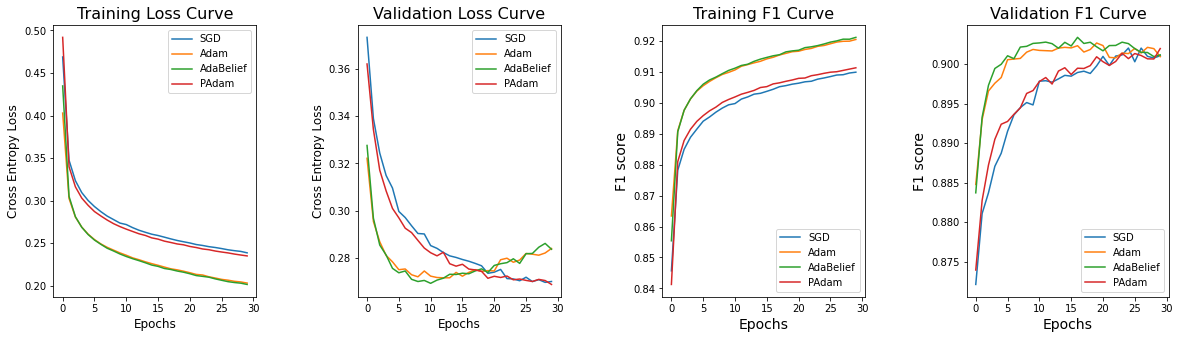

In [18]:
from matplotlib.pyplot import MultipleLocator
epo=[i for i in range(30)]
plt.figure(figsize=(20, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.5)
plt.subplot(141)
plt.title("Training Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['train_loss'], label="SGD")
plt.plot(epo, adam_df['train_loss'], label="Adam")
plt.plot(epo, belief_df['train_loss'], label="AdaBelief")
plt.plot(epo, padam_df['train_loss'], label="PAdam")

x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()


plt.subplot(142)

plt.title("Validation Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_loss'], label="SGD")
plt.plot(epo, adam_df['valid_loss'], label="Adam")
plt.plot(epo, belief_df['valid_loss'], label="AdaBelief")
plt.plot(epo, padam_df['valid_loss'], label="PAdam")
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()
plt.subplot(143)
plt.title("Training F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['train_f1'], label="SGD")
plt.plot(epo, adam_df['train_f1'], label="Adam")
plt.plot(epo, belief_df['train_f1'], label="AdaBelief")
plt.plot(epo, padam_df['train_f1'], label="PAdam")

x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()


plt.subplot(144)

plt.title("Validation F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_f1'], label="SGD")
plt.plot(epo, adam_df['valid_f1'], label="Adam")
plt.plot(epo, belief_df['valid_f1'], label="AdaBelief")
plt.plot(epo, padam_df['valid_f1'], label="PAdam")
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()
plt.savefig('./vgg_loss.png')
plt.show()

# Draw the structure of model

In [ ]:
!pip install torchviz
from torchviz import make_dot
my_model = VGG('VGG_ba_small')
out = my_model(torch.randn(64,1,224,224))
make_dot(out, dict(my_model.named_parameters())).render('model', format='png')

'model.png'